In [1]:
dataset_root = "../dataset/"
images_dir = dataset_root + "complete/"
features_dir = dataset_root + 'handcrafted/'

recompute_features = False

In [2]:
import sys
import cv2 as cv
import matplotlib.pyplot as plt
import os
sys.path.append("..")

from keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from feature_extraction import build_feature_extractor
from similarity_search.neural_similarity_search import extract_features
from handcrafted_extraction import load_all_features, load_features

def builder():
    return build_feature_extractor(EfficientNetV2B0, 'top_dropout')

2024-01-07 11:53:01.440466: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-07 11:53:01.442359: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-07 11:53:01.468125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-07 11:53:01.468152: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-07 11:53:01.469122: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
(handcrafted_features, _) = load_all_features(features_dir, os.listdir(images_dir), load_color=True, load_lbp=True, load_gabor=False, load_sift=False, load_bow=False)
   

  0%|          | 0/130469 [00:00<?, ?it/s]

100%|██████████| 130469/130469 [00:03<00:00, 34057.01it/s]


In [4]:
batch_size = 128
image_size = (224, 224)

if recompute_features:
    extracted_features, filenames = extract_features(builder, images_dir, batch_size=batch_size, image_size=image_size, rebuild_interval=50, preprocessing=preprocess_input)

In [5]:
import os
import numpy as np
import pandas as pd
extracted_features_root = "./extracted_features/"
extracted_features_path = extracted_features_root + 'efficient_net_similarity'
filenames_path = extracted_features_root + 'efficient_net_similarity_filenames.csv'

In [6]:
if recompute_features:
    os.makedirs(extracted_features_root, exist_ok=True)
    names_df = pd.DataFrame({'filename': filenames})
    names_df.to_csv(filenames_path, header=None)
    np.save(extracted_features_path, extracted_features)

In [7]:
extracted_features = np.load(extracted_features_path + '.npy')
filenames = pd.read_csv(filenames_path, header=None).iloc[:, 1].values
files = os.listdir(images_dir);

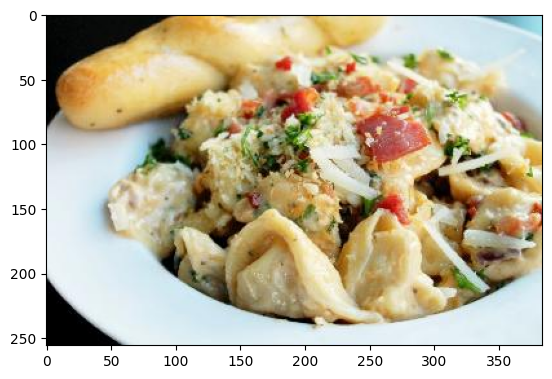

In [59]:
index = np.random.randint(len(files), size=1)[0]
img = cv.imread(images_dir + files[index])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB);

lplt.imshow(img)

In [74]:
from similarity_search.neural_similarity_search import find_similar, find_similar_handcrafted
query_path = images_dir + files[index]
images_to_consider = 1000
nn_most_similar, distances = find_similar(builder(), query_path, extracted_features, filenames, preprocess_input, output_number=images_to_consider)
handcrafted_most_similar, distances = find_similar_handcrafted(images_dir, handcrafted_features, query_path, False, output_number=images_to_consider)
similar_index = 0

1/1 [==============================] - 1s 960ms/step


In [78]:
intersection = np.intersect1d(handcrafted_most_similar, nn_most_similar)
print('Images on which handcrafted and nn agree: ', len(intersection), '/', images_to_consider)

Images on which handcrafted and nn agree:  26 / 1000


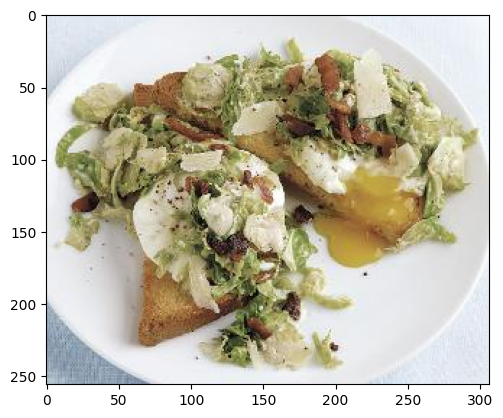

In [87]:
use_intersection = True
use_nn = True

most_similar_filenames = nn_most_similar if use_nn else handcrafted_most_similar
most_similar_filenames = intersection if use_intersection else most_similar_filenames

img = cv.imread(images_dir + most_similar_filenames[similar_index])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB);

plt.imshow(img)
similar_index += 1

In [ ]:
import cv2 as cv
cv.destroyAllWindows()
for image_name in most_similar_filenames:
    im = cv.imread(images_dir + image_name)
    cv.imshow(image_name, im)
    cv.waitKey()

In [ ]:
cv.destroyAllWindows()